In [1]:
%load_ext autoreload
%autoreload 2

import os, time
import numpy as np
import trace_util
import matplotlib.pyplot as plt
import xgboost as xgb
import veritas # pip install dtai-veritas

In [2]:
plt.rcParams.update({'font.size': 12})

In [3]:
xtrain, ytrain_mc = trace_util.load_trace_file("Trace_TRAIN.txt")
xtest, ytest_mc = trace_util.load_trace_file("Trace_TEST.txt")

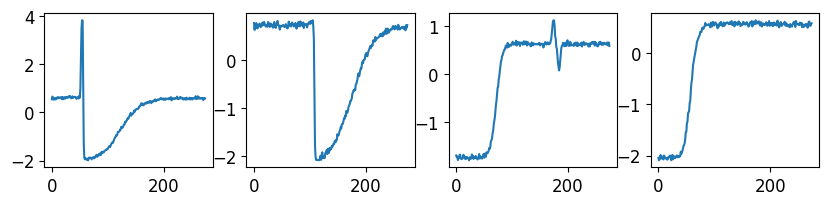

In [4]:
fig, axs = plt.subplots(1, 4, figsize=(10, 2))

axs[0].plot(xtrain[np.argmax(ytrain_mc==0),:])
axs[1].plot(xtrain[np.argmax(ytrain_mc==1),:])
axs[2].plot(xtrain[np.argmax(ytrain_mc==2),:])
axs[3].plot(xtrain[np.argmax(ytrain_mc==3),:])

plt.show()

In [5]:
# binary classification for simplicity
ytrain, ytest = ytrain_mc==1, ytest_mc==1

In [6]:
params = {
    #"num_class": 4,
    #"objective": "multi:softmax",
    #"eval_metric": "merror",
    
    "objective": "binary:logistic",
    "eval_metric": "error",
    
    "tree_method": "hist",
    "seed": 135,
    "max_depth": 3,
    "learning_rate": 0.2,
    "colsample_bynode": 0.2,
    "subsample": 0.2
}
num_trees = 25

dtrain = xgb.DMatrix(xtrain, ytrain)
dtest = xgb.DMatrix(xtest, ytest)
model = xgb.train(params, dtrain, num_boost_round=num_trees,
                  evals=[(dtrain, "train"), (dtest, "test")])

[0]	train-error:0.21000	test-error:0.29000
[1]	train-error:0.21000	test-error:0.29000
[2]	train-error:0.21000	test-error:0.29000
[3]	train-error:0.21000	test-error:0.29000
[4]	train-error:0.00000	test-error:0.08000
[5]	train-error:0.00000	test-error:0.08000
[6]	train-error:0.00000	test-error:0.08000
[7]	train-error:0.00000	test-error:0.08000
[8]	train-error:0.01000	test-error:0.09000
[9]	train-error:0.01000	test-error:0.05000
[10]	train-error:0.01000	test-error:0.07000
[11]	train-error:0.01000	test-error:0.04000
[12]	train-error:0.01000	test-error:0.04000
[13]	train-error:0.01000	test-error:0.04000
[14]	train-error:0.01000	test-error:0.04000
[15]	train-error:0.01000	test-error:0.04000
[16]	train-error:0.00000	test-error:0.04000
[17]	train-error:0.00000	test-error:0.04000
[18]	train-error:0.00000	test-error:0.04000
[19]	train-error:0.00000	test-error:0.04000
[20]	train-error:0.00000	test-error:0.03000
[21]	train-error:0.00000	test-error:0.03000
[22]	train-error:0.00000	test-error:0.0300

In [7]:
at = veritas.get_addtree(model)


| XGBOOST's base_score
|   base_score diff std      2.0072345340244863e-08 OK
|   base_score reported      0.23866731
|   versus manually detected -0.8379497682042419
|   abs err                  1.076617078204242
|   rel err                  4.510953252057192
|   (!) base_score NOT THE SAME with relative tolerance 0.00025



In [8]:
print(at[0])

Node(id=0, split=[F9 < 0.601209], sz=3, left=1, right=2)
├─ Leaf(id=1, sz=1, value=[-0.184564])
└─ Leaf(id=2, sz=1, value=[0.245714])



In [9]:
# Check whether output of xgboost and corresponding AddTree match
err = np.max(np.abs(at.eval(xtest).ravel() - model.predict(dtest, output_margin=True)))
if err < 1e-5:
    print("OK, model outputs are the same")
else:
    print("WARNING, model outputs not the same")

# This is also implemented in Veritas:
is_conversion_ok = veritas.test_conversion(at, xtest, model.predict(dtest), silent=False)
print("Conversion OK?", is_conversion_ok)

OK, model outputs are the same
test_conversion: no problems detected (rel_tol 0.00025)
Conversion OK? True


In [10]:
# FROM CLASS 0 -> CLASS 1
base_example = xtest[ytest_mc==0, :][16,:]
eps = 0.3

config = veritas.Config(veritas.HeuristicType.MAX_OUTPUT)
config.ignore_state_when_worse_than = 0.0
prune_box = [veritas.Interval(x-eps, x+eps) for x in base_example]
search = config.get_search(at)

tstart = time.time()
while search.num_solutions() == 0:
    pass
    print(search.steps(100))
tstop = time.time()
    
sol = search.get_solution(0) # best solution is at index 0
adv_example = veritas.get_closest_example(sol, base_example, eps=1e-4)

print(f"found an adversarial example for `base_example` with raw output {sol.output:.3f} in {(tstop-tstart)*1000:.1f}ms")
for feat_id, ival in sol.box().items():
    x = base_example[feat_id]
    print(" - F{:<3d} {:<22s} base value={:7.4f}, in? {:d}".format(feat_id, repr(ival), x, ival.contains(x)))

StopReason.OPTIMAL
found an adversarial example for `base_example` with raw output 1.342 in 0.1ms
 - F0   Interval(>=0.663867)   base value= 0.5792, in? 0
 - F3   Interval(>=0.660472)   base value= 0.5170, in? 0
 - F5   Interval(>=0.653347)   base value= 0.5537, in? 0
 - F7   Interval(>=0.696791)   base value= 0.5965, in? 0
 - F9   Interval(>=0.601209)   base value= 0.5037, in? 0
 - F16  Interval(>=0.658673)   base value= 0.5811, in? 0
 - F18  Interval(>=0.692481)   base value= 0.6242, in? 0
 - F21  Interval(>=0.62866)    base value= 0.5810, in? 0
 - F23  Interval(>=0.629155)   base value= 0.5257, in? 0
 - F47  Interval(>=0.645616)   base value= 2.2385, in? 1


           base       adv
xgb proba [0.05540035 0.79280543]
 at proba [0.05540035 0.79280545]
 at raw   [-2.83617529  1.34191966]


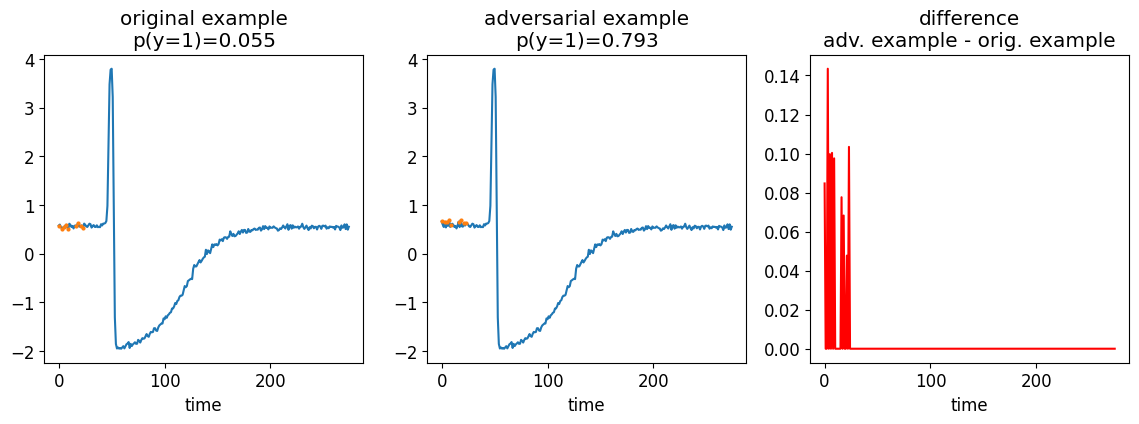

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
axs[0].plot(base_example)
axs[1].plot(adv_example)
axs[0].plot(np.nonzero(adv_example!=base_example)[0], base_example[adv_example!=base_example], ".", ms=4)
axs[1].plot(np.nonzero(adv_example!=base_example)[0], adv_example[adv_example!=base_example], ".", ms=4)
axs[2].plot(adv_example-base_example, color="red")

# Just to be sure, evaluate two example in the original xgboost model
base_and_adv = np.vstack((base_example, adv_example))
ypred = model.predict(xgb.DMatrix(base_and_adv))
print("           base       adv")
print("xgb proba", ypred)
print(" at proba", at.predict(base_and_adv).ravel())
print(" at raw  ", at.eval(base_and_adv).ravel())

axs[0].set_title(f"original example\np(y=1)={ypred[0]:.3f}")
axs[1].set_title(f"adversarial example\np(y=1)={ypred[1]:.3f}")
axs[2].set_title("difference\nadv. example - orig. example")

for ax in axs:
    ax.set_xlabel("time")

plt.show()